
<mark>**<font size=5>20240719   Test Q-learning (table-based) + Frozenlake冰湖 </font>**</mark>

代码整理自： https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/

* 理论：  https://blog.csdn.net/weixin_46034116/article/details/138874447




<img src=attachment:9b059540-991d-42cd-ab1f-0e9a45f76ec1.png width=70% />

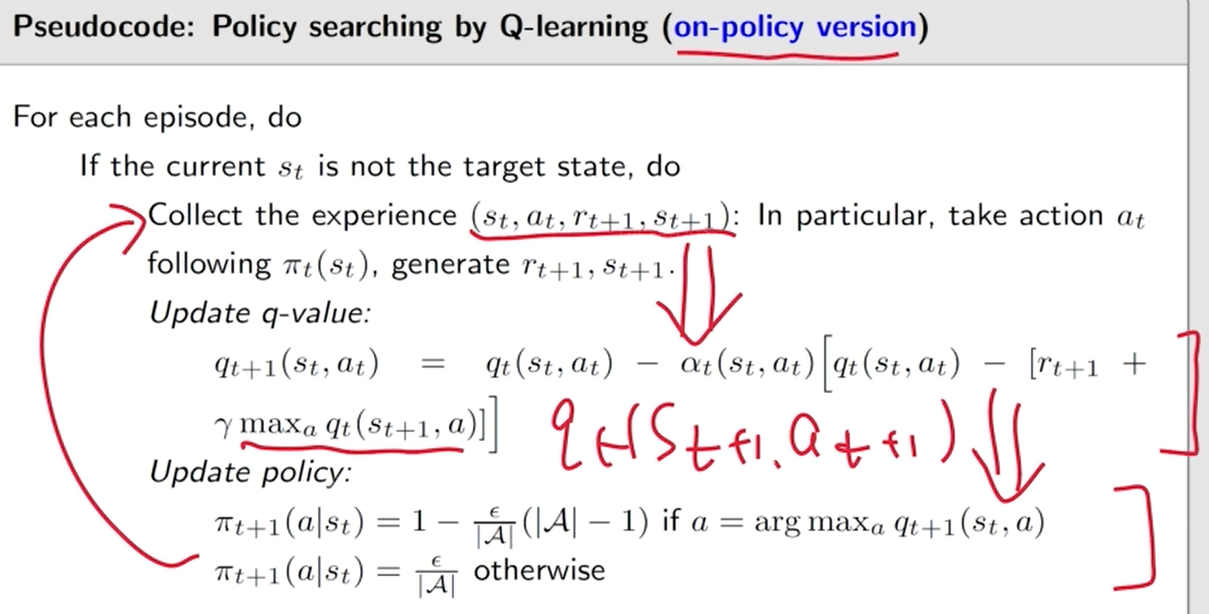

---  -----
---  -----

Frozenlake 基本信息：

https://gymnasium.farama.org/environments/toy_text/frozen_lake/


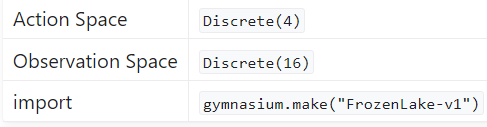

Frozenlake 要求在冰湖上行走，从起点到终点， 穿过冰湖而**不掉进任何洞里**。由于冰湖的滑溜性质，玩家可能并不总是朝着预定的方向移动。

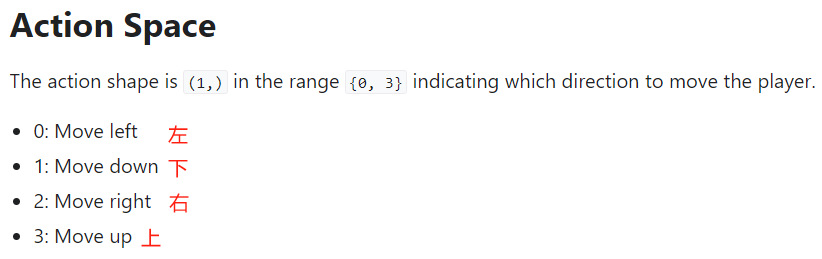


观察空间： 位置 current_row * nrows + current_col 


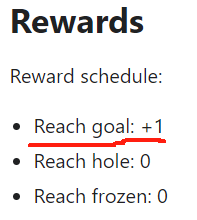

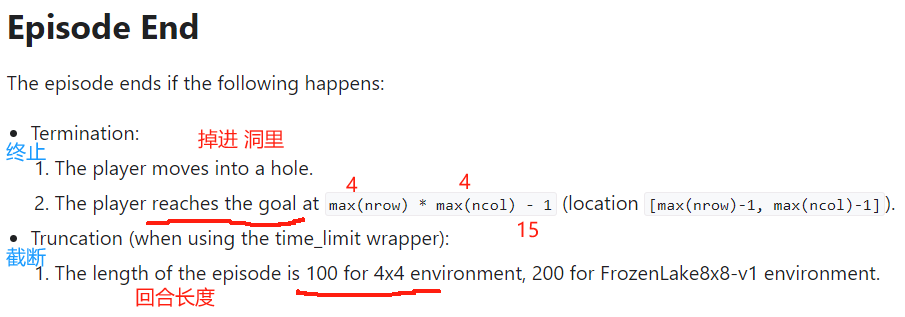

---  -----
---  -----


In [30]:
pip install seaborn

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple/

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install gymnasium 

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple/

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Code

In [32]:
from pathlib import Path # 路径
from typing import NamedTuple # 定义 超参数 

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns 
from tqdm import tqdm # 循环模块 进度条显示

import gymnasium as gym 
from gymnasium.envs.toy_text.frozen_lake import generate_random_map 

sns.set_theme()


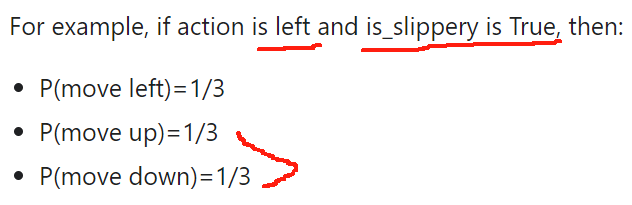

In [33]:
# 参数

class Params(NamedTuple):
    total_episodes: int  # Total episodes  回合长度
    learning_rate: float  # Learning rate  学习率
    gamma: float  #  Discounting rate 折扣因子 γ 
    epsilon: float  # Exploration probability  探索概率 ε
    map_size: int  # Number of tiles of one side of the squared environment 正方形冰面的边长 格子个数
    seed: int  # Define a seed so that we get reproducible results 设定种子，便于获取 可复现 的 实验结果
    is_slippery: bool  # 地面是否 滑
    # # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs 
    action_size: int  # Number of possible actions 动作个数
    state_size: int   # Number of possible states  状态个数
    proba_frozen: float  # Probability that a tile is frozen 某个格子是冰的概率， 即不是冰洞
    savefig_folder: Path  # Root folder where plots are saved
    
    
params = Params(
    total_episodes = 2000,  # 2000
    learning_rate = 0.8,
    gamma = 0.95,
    epsilon = 0.1,
    map_size = 5,
    seed = 123,
    is_slippery = False,
    n_runs = 20,  # 20 测试时改小些  比如 2
    action_size = None,
    state_size = None,
    proba_frozen = 0.9,
    savefig_folder = Path("./RLTestResults/img/tutorials/"),  
)

# params 



# 设置 种子  随机数生成器(Random Number Generator,RNG)
rng = np.random.default_rng(params.seed)

# 如果 图片文件夹不在， 创建
params.savefig_folder.mkdir(parents=True, exist_ok=True)


# 冰湖 环境

env = gym.make(
    "FrozenLake-v1",
    is_slippery = params.is_slippery,
    render_mode = "rgb_array",
    desc = generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)


# 设置 环境的动作数 和 状态数
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size： {params.action_size}")
print(f"State size： {params.state_size}")



Action size： 4
State size： 25


In [34]:
print(env.spec.reward_threshold)

0.7


https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng

## Q-leaning 算法【table】的一些模块

In [35]:

######  Q-leaning 算法【table】的一些模块

# 创建 Q-table
# ε-greedy 地选择每一步要执行的动作


class Qlearning:
    # 初始化参数
    def __init__(self, learning_rate, gamma, state_size, action_size): 
        self.state_size = state_size
        self.action_size = action_size 
        self.learning_rate = learning_rate 
        self.gamma = gamma 
        self.reset_qtable() # 初始化 self.qtable
        
    # 更新 Q 值： q'(s, a) ⇦ q(s, a)-lr [q(s, a)-(r- γ * max q(s', a))]
    def update(self, state, action, reward, new_state):
        """Update Q'(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a) - Q(s,a)]"""
        # [] 里的 差
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        # Q'(s,a)
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update
    
    # 重置 q 表  用于每个回合 
    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))  # 注意 numpy.zeros 的 shape 要么是 int 要么是 tuple

## 这里的代码实现 和 理论不完全一样
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon 
        
    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        
        # 探索-利用 权衡阈值
        explor_exploit_tradeoff = rng.uniform(0, 1) # 从均匀分布中抽取样本。
        
        # Exploration 探索
        if explor_exploit_tradeoff < self.epsilon:  # 小于 
            action = action_space.sample() # 随机选动作
            
        # Exploitation 利用 ： 选取当前状态中 能获得最大 Q 值的动作
        else:
            if np.all(qtable[state, :]) == qtable[state, 0]: # 如果 Q 值一样， 随机选 ！！
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :]) # 选取 q 值最大 相应的动作
                
        return action


* https://numpy.org/doc/stable/reference/generated/numpy.zeros.html#numpy-zeros
*  rng.uniform(0, 1)  https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.uniform.html#numpy.random.Generator.uniform

## Running the environment


In [36]:
# the learner and the explorer 学习者 和 探索者

learner = Qlearning(
    learning_rate = params.learning_rate,
    gamma = params.gamma,
    state_size =params.state_size,
    action_size=params.action_size,
)

explorer = EpsilonGreedy(
    epsilon = params.epsilon,
)


In [37]:
# 这将是我们运行环境的主要函数，直到达到最大 回合数 params.total_episodes。
# 考虑随机性，我们还将进行多次 运行。

def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []
    
    for run in range(params.n_runs): # 考虑随机性， 运行 几次
        learner.reset_qtable()  # 在 runs 之间 重置 Q-table
        
        for episode in tqdm(episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False):
            state = env.reset(seed=params.seed)[0]  # 重置环境
            step = 0
            done = False 
            total_rewards = 0 
            
            while not done:
                action = explorer.choose_action(
                    action_space = env.action_space, state=state, qtable=learner.qtable
                )
                
                # 记录 状态 和  动作
                all_states.append(state)
                all_actions.append(action)
                
                # Take the action (a) and observe the outcome state(s') and reward (r)
                # 执行动作 (a)并观察 结果状态(s)和奖励(r)
                new_state, reward, terminated, truncated, info = env.step(action)
                
                done = terminated or truncated
                
                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )
                
                total_rewards += reward 
                step += 1
                
                state = new_state 
                
            # 记录所有的 奖励 和 steps 
            rewards[episode, run] = total_rewards 
            steps[episode, run] = step 
            
        qtables[run, :, :] = learner.qtable 
        
    return rewards, steps, episodes, qtables, all_states, all_actions
    

        

## 可视化

In [38]:
# 将 数据 转成 DataFrame 格式

def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    ) 
    
    res['cum_rewards'] = rewards.cumsum(axis=0).flatten(order="F")  # 按列累加  每列为 一个 run 的
    res["map_size"] = np.repeat(f"{map_size}×{map_size}", res.shape[0])
    
    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}×{map_size}", st.shape[0])
    
    return res, st 


**numpy.matrix.flatten**
https://numpy.org/doc/stable/reference/generated/numpy.matrix.flatten.html#numpy.matrix.flatten
All N elements of the matrix are placed into a single row.

矩阵的所有 N 个元素都放在一行中。

------

numpy.tile
https://numpy.org/doc/stable/reference/generated/numpy.tile.html#numpy.tile
numpy.tile(A, reps)

通过多次重复 A 来构造一个数组。

reps: 在每个轴上重复的次数


------

我们想绘制出智能体最后学到的策略。为此，我们将:

1. 从 Q 表中提取每个状态的最佳 Q 值
2. 得到这些 Q 值对应的最佳行动
3. 将每个动作映射到一个箭头上，这样我们就可以看到它。

In [39]:
# 可视化 最终的策略

def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    # 将 动作 映射成 箭头
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    
    directions = {0:"←", 1: "↓", 2: "→", 3: "↑"} # 动作 映射 到  箭头
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # 机器上的最小浮动数
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps: # 0 的时候啥也没学到， 不管
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions           

使用下面的函数，我们将在左侧绘制模拟的最后一帧。

如果智能体学会了一个很好的策略来解决任务，我们期望在视频的最后一帧的宝藏的方块上看到它。

在右边，我们画出智能体学到的策略。每个箭头将代表针对每个方块/状态选择的最佳行动。

In [40]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    # 绘制仿真的最后一帧 以及 学到的策略
    
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)
    
    # 绘制最后一帧
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")
    
    # 绘制 策略
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    
    for _, spine in ax[1].spines.items(): # 设置图片四周边框
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}×{map_size}.png"
    fig.savefig(params.savefig_folder/img_title, bbox_inches="tight")
    plt.show()
    
    

In [41]:
# 作为完整性检查，我们将使用以下函数绘制状态和动作的分布:

def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    # 绘制 状态 和 动作 的分布
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax = ax[0], kde=True)
    ax[0].set_title("states")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title=f"frozenlake_states_actions_distrib_{map_size}×{map_size}.png"
    fig.savefig(params.savefig_folder/img_title, bbox_inches="tight")
    plt.show()


# 主函数

Map size： 4×4


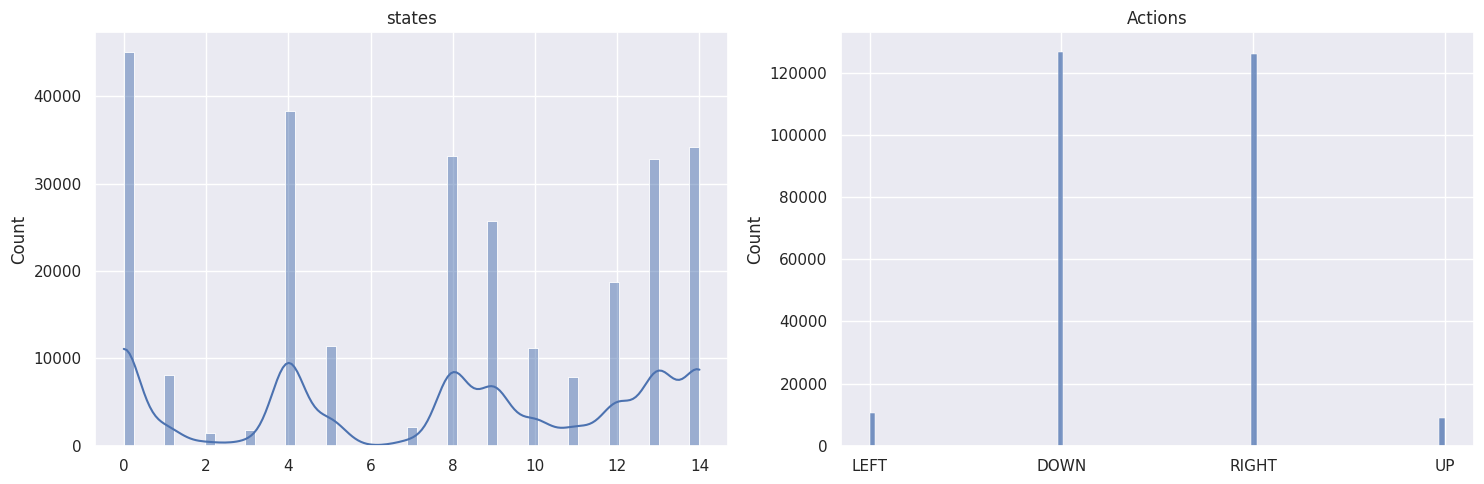

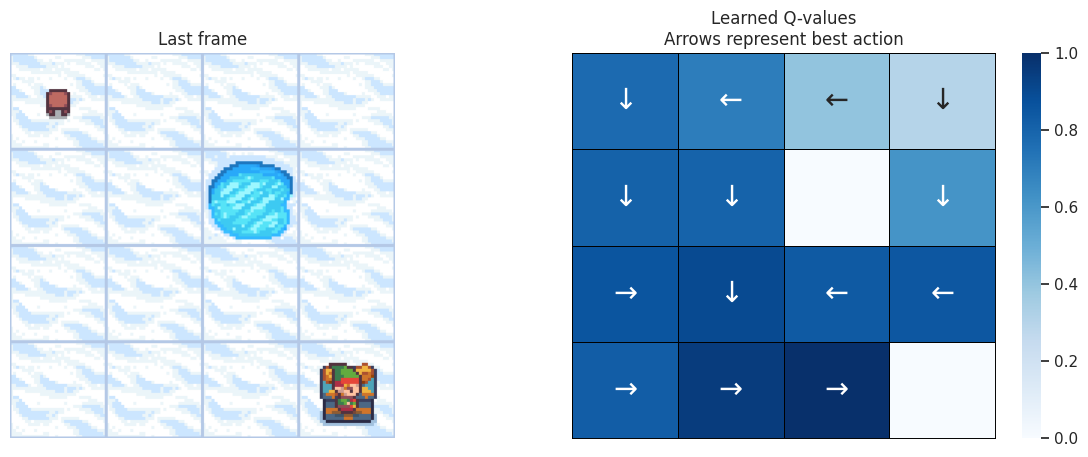

Map size： 7×7


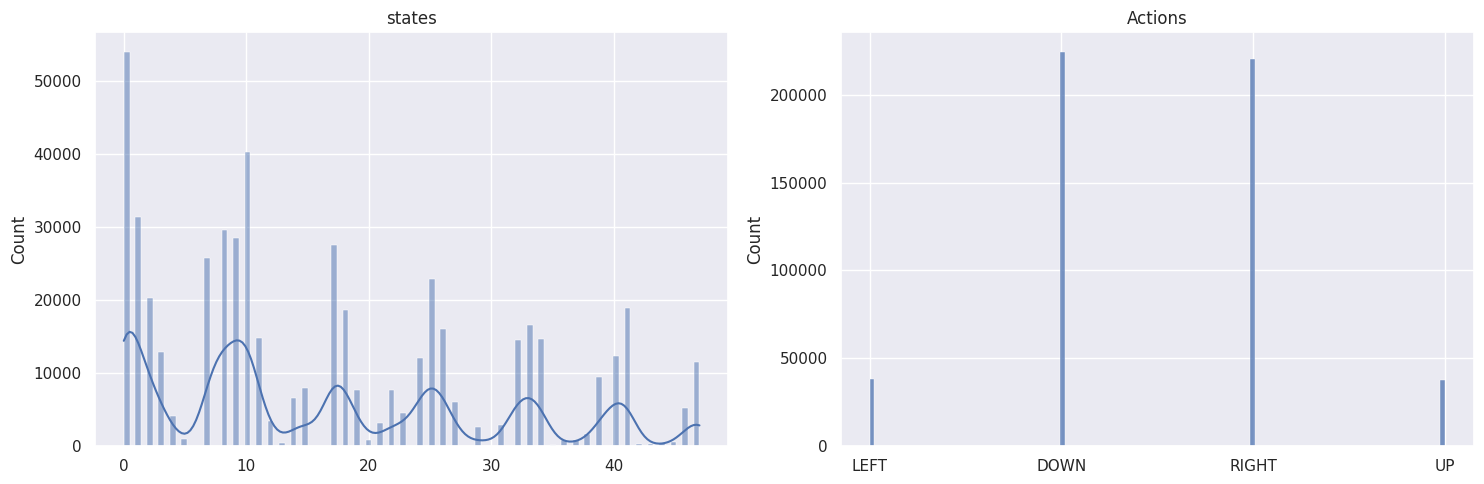

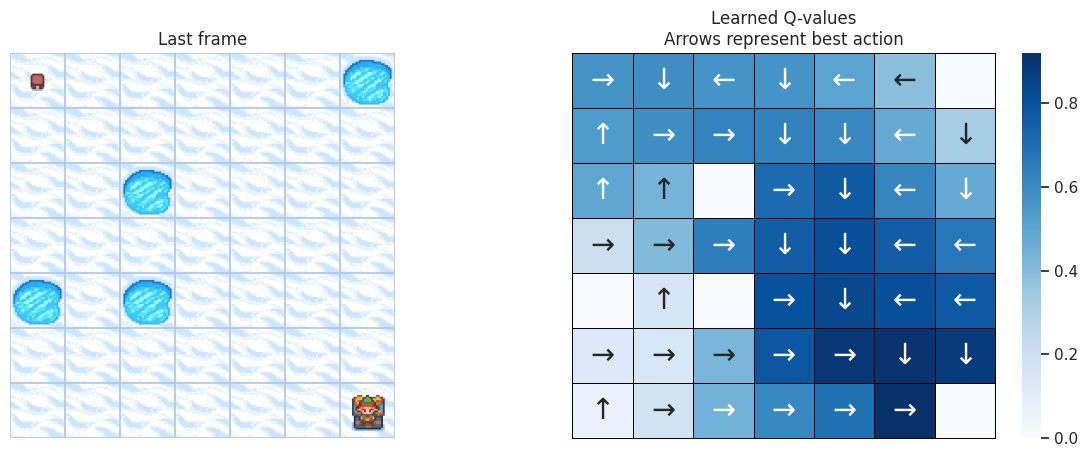

Map size： 9×9


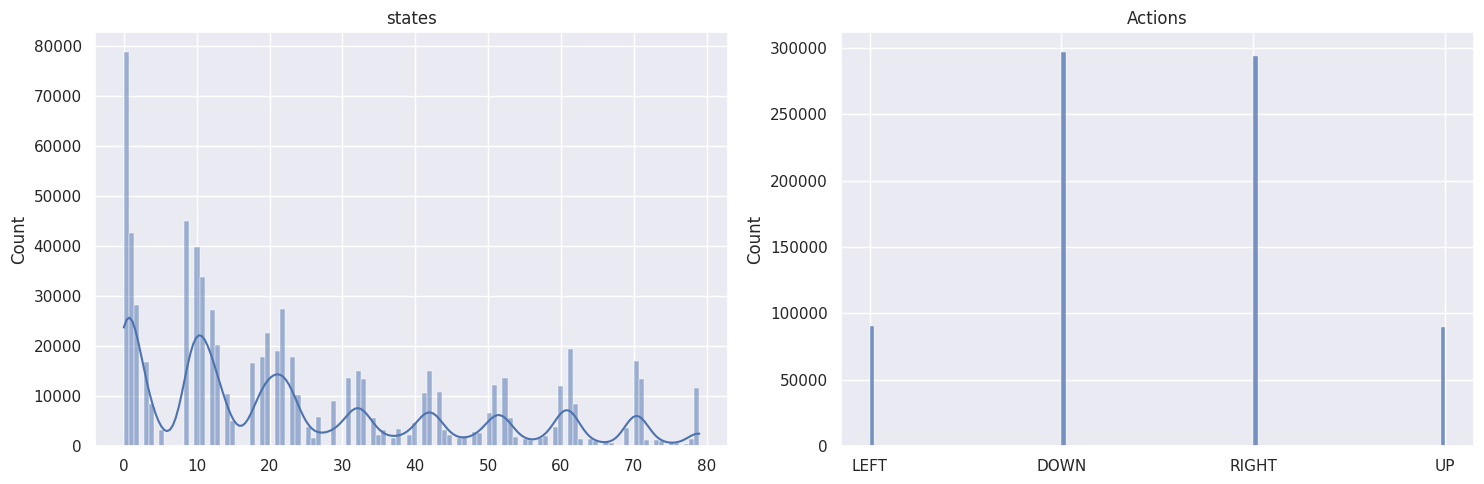

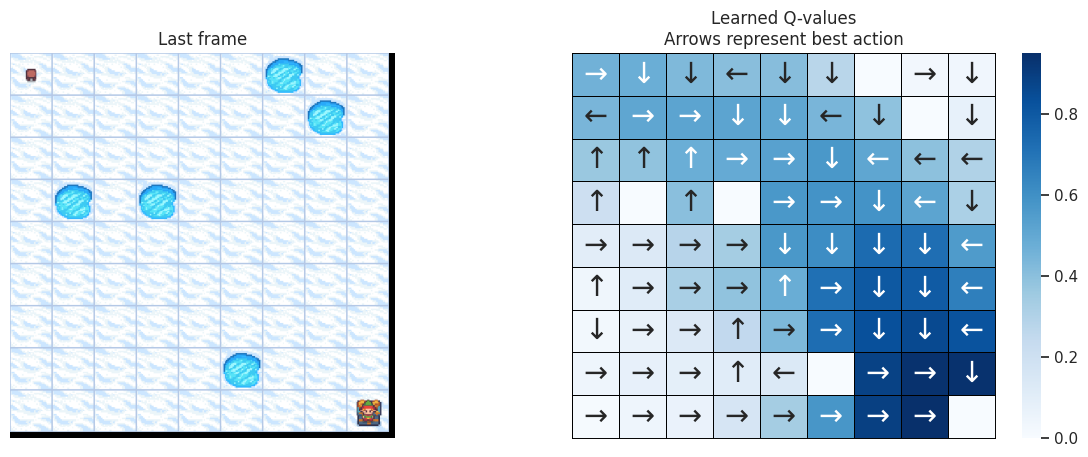

Map size： 11×11


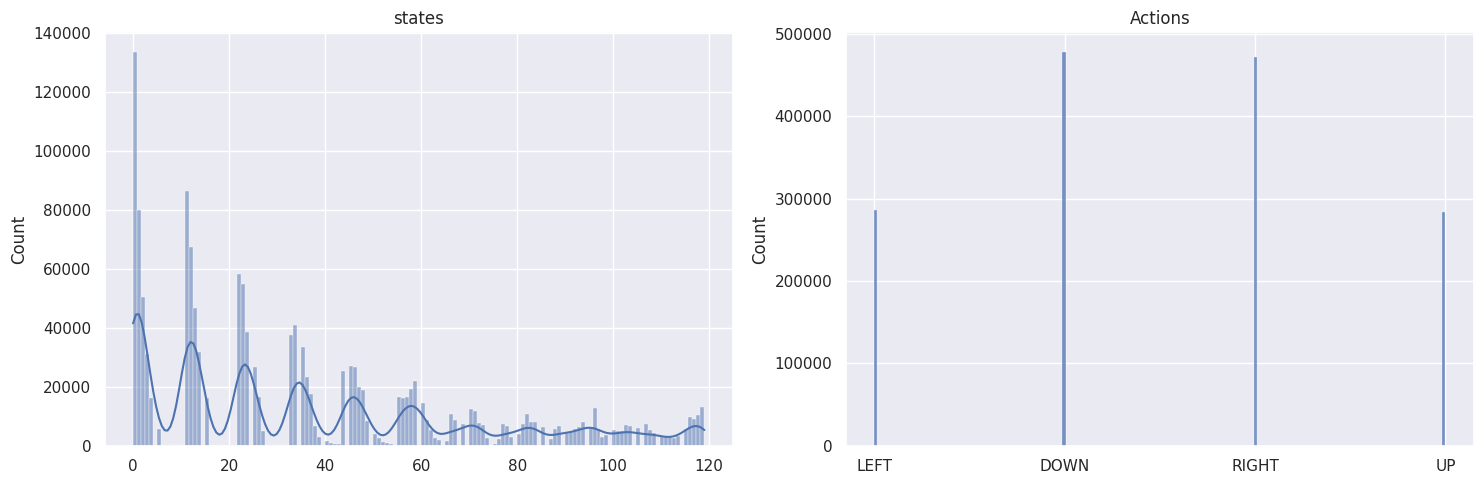

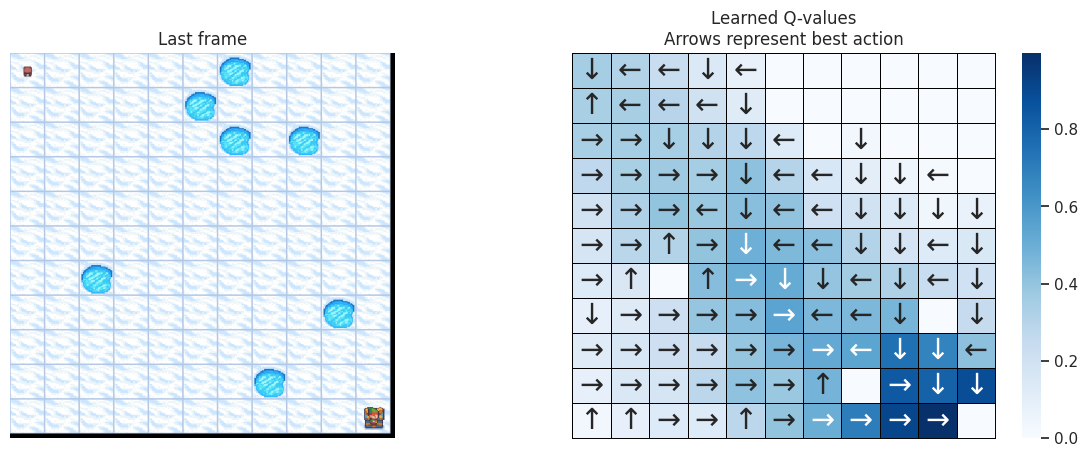

In [42]:
# 让 agent 在尺寸依次递增的地图上 探索。
# 4、7、9、11

map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()  # 
st_all = pd.DataFrame() # 记录 每个回合结束的 最终步数  steps
 
for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # 设置种子，以便在采样动作空间时获得可重复的结果
    
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    
    eplorer = EpsilonGreedy(epsilon=params.epsilon,)
    
    print(f"Map size： {map_size}×{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()
    
    # 将 结果存在 DataFrame 中
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0) # 不同 runs 间 的均值
    
    
    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    
    # 
    plot_q_values_map(qtable, env, map_size)
    
    env.close()


向下和向右的行动被选择得更频繁，这是有道理的，因为 agent 从地图的左上角开始，需要找到通往右下角的路。

此外，地图越大，玩家访问的 states/tiles 就越少。

为了检查我们的智能体是否在学习，我们想要绘制**奖励的累积总和**，以及直到**回合结束所需的步数**。

如果我们的智能体正在学习，我们希望看到**累积的奖励增加，解决任务的步骤减少**。

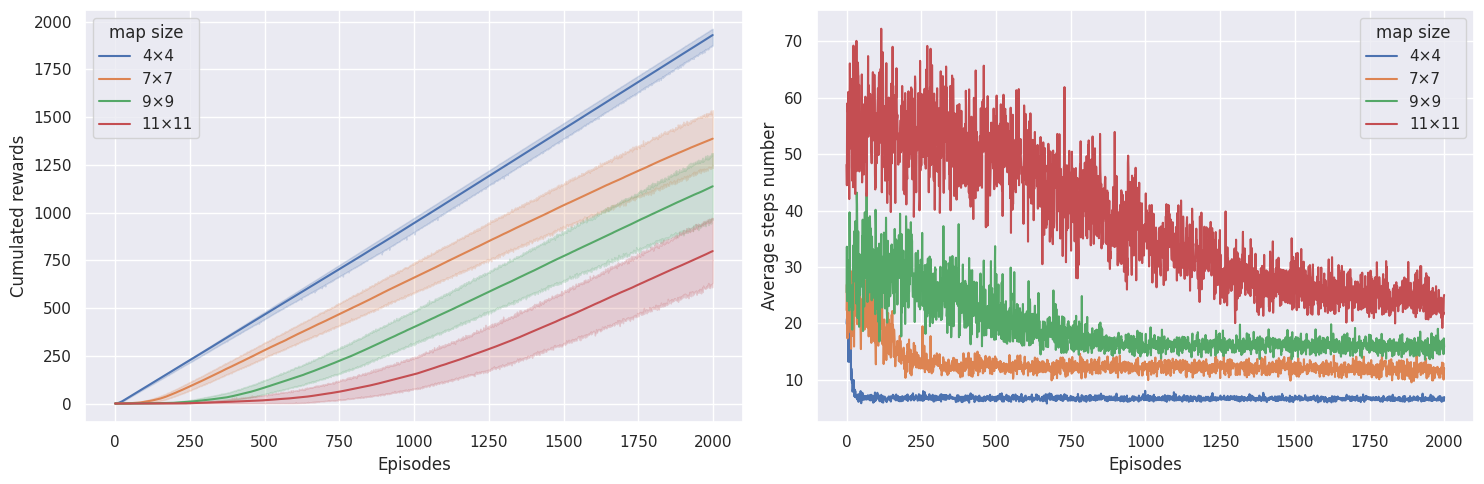

In [43]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    # 绘制之前 记录的 步数 和 奖励
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x = "Episodes", y="cum_rewards", hue="map_size",
        ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")
    
    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size",
                ax=ax[1])
    ax[1].set(ylabel="Average steps number")
    
    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder/img_title, bbox_inches="tight")
    plt.show()
    
    
plot_steps_and_rewards(res_all, st_all)

* 在 4 × 4 的地图上，学习收敛得很快，
* 而在 7 × 7 的地图上，智能体需要 300 个回合，
* 在 9 × 9 的地图上需要 800 个回合，
* 而在 11 × 11 的地图上，需要 1800 个回合才能收敛。


有趣的是，智能体似乎在 9 × 9 的地图上比在 7 × 7 的地图上得到了更多的奖励，这<mark>可能意味着它在 7 × 7 的地图上没有达到最优策略。</mark>

最后，如果智能体agent  没有得到任何奖励，奖励就不会在 Q 值中传播，智能体agent  也不会学到任何东西。

根据我使用 $\epsilon$-greedy 以及那些超参数和环境设置的经验，拥有超过 11 × 11 块格子的地图开始变得难以解决。

也许使用不同的探索算法可以克服这个问题。

另一个影响很大的参数是 proba_frozen，即贴图被冻结的概率。如果洞太多，即 $p < 0.9$，那么 Q-learning 就很难避免掉入洞并获得奖励信号。

# —— 查看 API

* https://matplotlib.org/stable/api/index.html
* https://seaborn.pydata.org/api.html
